## Custom Keras Generator
####This material is mainly aiming to crystallize my knowledge. Any suggestion or correction would be gladly accepted
<br><br>
A custom generator is useful in many cases such as :
- Training on a huge dataset which cannot fit the GPU memory
- Dataset doesn't contain enough data
- Loading, transforming batches on the fly before to feed it to the network
- Online training where new data can be automatically transformed and fed to the network for continuous learning

<br><br>
base on: https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a

In [1]:
import os
from PIL import Image
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from random import *

seed = np.random.randint(1234)

In [2]:
def folders_filenames_to_csv():
    '''Buid a csv dataset 
    '''
    path = 'data'
    file_paths = []
    animals = []
    
    for animal in ['cat', 'panda']:
        
        for root, dirs, files in os.walk(os.path.join(path, animal), topdown=False):
            for file in files:
                file_paths.append(os.path.join(root, file))
                animals.append(animal)
                
    df = pd.DataFrame({'animal':animals, 'path':file_paths})
    df.to_csv('data.csv',index=False)

folders_filenames_to_csv()

## Generator
The following generator loads a dataset from a CSV file and takes random samples. It then applies data augmentation applying transformations on the pictures. The function build_generator() iterate the generation of data in a while loop and yield it at each epoch of the training phase.

The transformations strength depends on the number of epochs. It follows the intuition that, with more complicated datasets, starting the training with dramatic transformations would prevent the network to learn properly. By setting the current epoch as a value for the strength, transformations increase progressively.

In [33]:
def data_augmentation(path, strength):
    '''Load an image from a path and apply transformation
    return an numpy array
    '''
    im = Image.open(path)
    im = im.resize((240, 180))
    #rotation
    im = im.rotate(uniform(-strength,strength)*0.5, center=(120, 140))

    #translation
    left_right = uniform(-strength,strength)
    up_down = uniform(-strength ,strength)
    im = im.transform(im.size, Image.AFFINE, (1, 0, left_right, 0, 1, up_down))
    
    #any other transformations..
    
    return  np.asarray(im)



def get_xbatch(df, da_strength):
    '''Load batch with multi-thread
    '''
    paths = list(df['path'])
    
    with Parallel(n_jobs=10, verbose=0, prefer='threads') as ex:
        x = ex(delayed(data_augmentation)(paths[i], da_strength)
               for i in range(len(paths)))
        
    return np.stack(x, axis=0)



def get_ybatch(df):
    '''Get ground truth for the batch
    '''
    animals = list(df['animal'])
    animals = np.array([0 if animal!='panda' else 1 for animal in animals])
    
    return animals



def get_data(df, batch_size, da_strength):
    '''Return imgs as array and labels for each part of the face
    '''
    df =  df.sample(n=batch_size)
    X_batch = get_xbatch(df, da_strength)
    Y_batch = get_ybatch(df)

    return X_batch, Y_batch



def build_generator(df, batch_size):
    '''Build custom generator
    '''
    epochs = 0
    df = pd.read_csv('data.csv')
    while True:
        epochs += 1
        yield get_data(df, batch_size, epochs//2) 


        
def test_generator(df, batch_size, da_strength):
    '''Generate samples to test the generator
    '''
    return get_data(df, batch_size, da_strength)


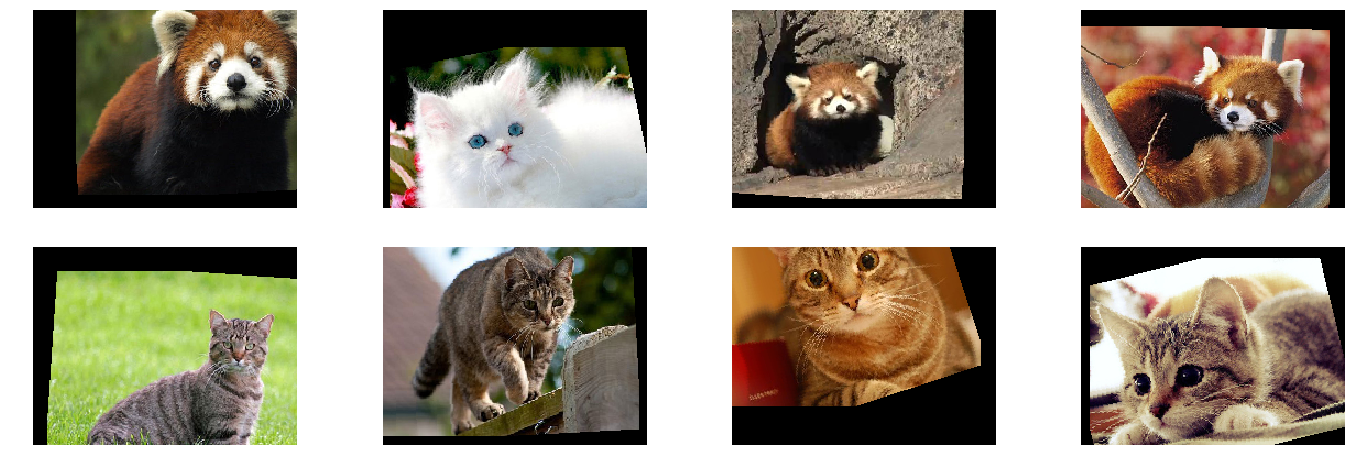

In [34]:
def plot_samples(columns,rows, data):

    fig, ax = plt.subplots(rows, columns, figsize=(rows*12,columns*2))

    for i in range(columns*rows):

        ax[i//(columns),i%columns].imshow(data[i])
        ax[i//(columns),i%columns].axis('off')

df = pd.read_csv('data.csv')    
data, _ = test_generator(df, 8, 40)
plot_samples(4, 2, data)

### Note:
If you need to generate batches for a multi-outputs network, the data returned by the generator should be like: 
<br><br>
yield (X_batch, {'output1': y1, 'output2': y2, ...} ))
<br>
https://stackoverflow.com/questions/38972380/keras-how-to-use-fit-generator-with-multiple-outputs-of-different-type/41872896

## Model

In [35]:
from keras.models import Model
from keras.optimizers import Adam
import keras.layers as KL
import keras.callbacks as KC

In [36]:
def build_model(width, height):
    '''Build the model architecture
    '''
    inputs = KL.Input(shape=(height, width, 3))
    x = KL.MaxPooling2D((2, 2))(inputs) 
    
    x = KL.SeparableConv2D(16, (3, 3), strides = (1, 1))(x)
    x = KL.BatchNormalization(axis = 3)(x)
    x = KL.Activation('relu')(x)
    x = KL.MaxPooling2D((2, 2))(x)
    x = KL.Dropout(0.25)(x)
    
    x = KL.Flatten()(x)
    x = KL.Dense(16, activation='relu')(x)
    x = KL.Dense(1, activation='sigmoid')(x)
    
    model = Model(
        inputs=inputs,
        outputs= x)

    return model



def prepare_model(model):
    '''Optimizer and callbacks
    '''
    model.compile(optimizer=Adam(lr=0.001),
                      loss='binary_crossentropy',
                      metrics=['acc'])

    checkpoint = KC.ModelCheckpoint(
        'models/model-{epoch:02d}-{acc:.2f}.h5', 
        monitor='acc', 
        verbose=0,
        save_best_only=True, 
        mode='auto')

    return [checkpoint]



def train_model(model, callbacks, batch_size):
    '''Train model
    '''
    df = pd.read_csv('data.csv')
    train = df.sample(frac = 0.8)
    validate = df.drop(train.index)
    
    train_steps =len(list(train['animal']))/batch_size
    val_steps =len(list(train['animal']))/batch_size
    
    train_gen = build_generator(train, batch_size)
    val_gen = build_generator(validate, batch_size)
    
    H = model.fit_generator(
        generator = train_gen, 
        validation_data = val_gen,
        steps_per_epoch=train_steps, 
        validation_steps = val_steps,
        epochs = 10, 
        callbacks= callbacks
    )


    return H

In [37]:
model = build_model(240, 180)    
callbacks = prepare_model(model)
H = train_model(model, callbacks, 8)

Epoch 1/10
2/1 [================================================] - 1s 605ms/step - loss: 2.6957 - acc: 0.5000 - val_loss: 1.0056 - val_acc: 0.7500
Epoch 2/10
2/1 [================================================] - 0s 171ms/step - loss: 1.3081 - acc: 0.6875 - val_loss: 0.3648 - val_acc: 0.6875
Epoch 3/10
2/1 [================================================] - 0s 170ms/step - loss: 0.3826 - acc: 0.6875 - val_loss: 0.3634 - val_acc: 0.6250
Epoch 4/10
2/1 [================================================] - 0s 170ms/step - loss: 0.3536 - acc: 0.6875 - val_loss: 0.4323 - val_acc: 0.5625
Epoch 5/10
2/1 [================================================] - 0s 170ms/step - loss: 0.4189 - acc: 0.5625 - val_loss: 0.3841 - val_acc: 0.6250
Epoch 6/10
2/1 [================================================] - 0s 170ms/step - loss: 0.3791 - acc: 0.5625 - val_loss: 0.4215 - val_acc: 0.5625
Epoch 7/10
2/1 [================================================] - 0s 170ms/step - loss: 0.3495 - acc: 0.7500 -

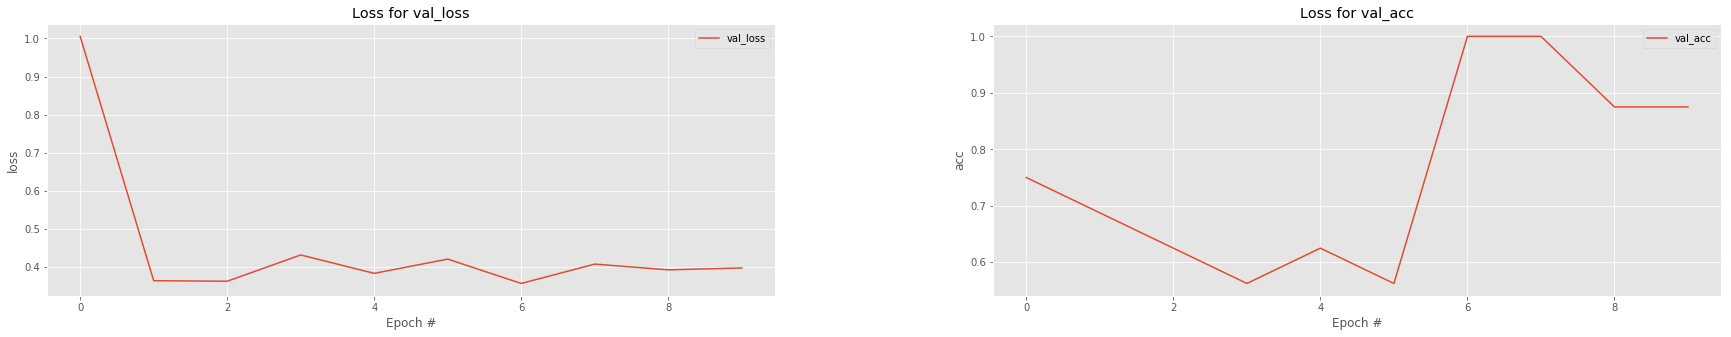

In [38]:
def analyse_results(epochs, history, metrics):

    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(1, 2, figsize=(30, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    for (i, l) in enumerate(metrics):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel(l.split('_')[-1])
        ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i].legend()
        
analyse_results(10, H, ['val_loss', 'val_acc'])